# Spam Text Classification
## Spam or Ham

In [55]:
import random
authors = ["Luke Wood", "Justin Ledford", "Traian Pop"]
random.shuffle(authors)
print("By", ', '.join(authors), "(in no particular order)")

By Justin Ledford, Luke Wood, Traian Pop (in no particular order)


## Data Background
The data we selected is a compilation of 5574 SMS messages acquired from a variety of different sources, broken down in the following way: 452 of the messages came from the Grumbletext Web Site, 3375 of the messages were taken from the NUS SMS Corpus (database with legitimate message from the University of Singapore), 450 messages collected from Caroline Tag's PhD Thesis, and the last 1324 messages were from *the* SMS Spam Corpus v.0.1 Big. 

Overall there were 4827 "ham" messages and 747 "spam" messages, and about 92,000 words.

## Purpose
This data was collected initially for studies on deciphering the differences between a spam or ham (legitimate) messages. Uses for this research can involve advanced spam filtering technology or improved data sets for machine learning programs. However, a slight problem with this data set, as with most localized language-based data sets, is that due to the relatively small area of sampling, there are a lot of regional data points (such as slang, acronyms, etc) that can be considering "useless" data if a much more generalized data set is wanted. 

This notebook ignores this shortcoming in order to analyze different model architectures.
___

## Preparation

In [ ]:
import pandas as pd
import numpy as np
import requests
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

descriptors_url = 'https://raw.githubusercontent.com/LukeWood/SpamVsHamDataAnalysis/master/data/SMSSpamCollection'
descriptors = requests.get(descriptors_url).text
texts = []


for line in descriptors.splitlines():
    texts.append(line.rstrip().split("\t"))

In [ ]:
texts[:5]

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...'],
 ['spam',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 ['ham', 'U dun say so early hor... U c already then say...'],
 ['ham', "Nah I don't think he goes to usf, he lives around here though"]]

After the first look at the data we noticed a lot of phone numbers. Since almost every number was unique we concluded that the numbers were irrelevant to consider as words. We considered grouping all number tokens into one token and analyze the presence of words, but we decided to first start by just removing the numbers.

In [ ]:
# Remove numbers
texts = list(zip([a for a,b in texts], [re.sub('((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d', 'PHONE_NUMBER', b) for a,b in texts]))

Citation: regex from google search top results/stack overflow

In [ ]:
import numpy as np
from keras.preprocessing import sequence

In [ ]:
X = [x[1] for x in texts]
y = [x[0] for x in texts]
X = np.array(X)
print(type(X))

<class 'numpy.ndarray'>


In [ ]:
import keras
y = [0 if y_ == "spam" else 1 for y_ in y]
y_ohe = keras.utils.to_categorical(y)
y_ohe

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

We assign spam as a value of 0 and ham as a value of one so that we can use precision score to measure false positive scores.

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(X)
sequences = pad_sequences(sequences)

MAX_TEXT_LEN = len(sequences[0]) # maximum and minimum number of words

We tokenize and measure the max length of the text using keras' tokenizer.

### Cross Validation Method

We now have an embedding matrix for our word index.

Finally, we split our data into training data and testing data.  We stratify the data on y_ohe to ensure that we get a fair representation of the spam and ham messages.  We believe this to be appropriate because each model needs to see a fair number of both spam messages and ham messages to ensure it does not overtrain on either.

In [ ]:
from sklearn.model_selection import train_test_split
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(sequences, y_ohe, test_size=0.2,
                                                            stratify=y_ohe, 
                                                            random_state=42)
NUM_CLASSES = len(y_train_ohe[0])
NUM_CLASSES

2

### Evaluation Metrics
For a spam filter the largest cost should be false positives.  It would be incredibly frustrating to have a real text filtered out.  Due to this models are evaluated in accordance to this.  To evaluate false positives as a loss function, we must implement a precision score metric which has been removed from keras.  Luckily, the old code is available in a one of keras' old versions.

In [ ]:
# Old version of keras had precision score, copied the code to re-implement it.
import keras.backend as K
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

## Modeling
To avoid the need for training our own embedding layer which is incredibly computationally expensive, we load up a pretrained [GloVe](https://nlp.stanford.edu/projects/glove/) embedding.

[You can read more about GloVe embeddings here](https://nlp.stanford.edu/projects/glove/)
 
**Warning: this is a big download**

In [ ]:
import time
import zipfile
from os import path
import os
import sys
from urllib.request import urlretrieve
appdata = path.expanduser(path.join("~", ".glove"))
if not path.isdir(appdata):
    os.mkdir(appdata)
    
GLOVE_DL = "http://nlp.stanford.edu/data/glove.6B.zip"
FNAMES = "glove.6B.%dd.txt" % 100

def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("\r...%d%%, %d MB, %d KB/s, %d seconds passed" %
            (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()

# Download embeddings if neccesary
def download_embeddings():
    if not path.exists(path.join(appdata,".downloaded")):
        print("Downloading pre-trained glove embeddings to %s" % (appdata))
        url = "http://nlp.stanford.edu/data/glove.6B.zip"
        urlretrieve(url, os.path.join(appdata, "glove.6B.zip"), reporthook)

        print("Unzipping glove embeddings.")
        zip_ref = zipfile.ZipFile(path.join(appdata,"glove.6B.zip"))
        zip_ref.extractall(appdata)
        zip_ref.close()

        print("Unzipping Complete: ",os.listdir(appdata),"were downloaded")
        open(path.join(appdata,".downloaded"),"a").close()
    else:
        print("Embedding files not found, but download directory already exists")

download_embeddings()

...100%, 822 MB, 2151 KB/s, 391 seconds passedUnzipping glove embeddings.
Unzipping Complete:  ['glove.6B.300d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.50d.txt', 'glove.6B.zip'] were downloaded


We load the values from the GloVe embedding into a numpy matrix.  This allows us to lookup the embedded values for a work easily.

In [ ]:
!ls /root/.glove

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt


In [ ]:
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open(path.join(appdata, 'glove.6B.100d.txt'), 'r')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(9008, 100)


Next we load these into a untrainable [keras Embedding layer](https://keras.io/api/layers/core_layers/embedding/).

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_TEXT_LEN,
                            trainable=False)
embedding_layer

Finally we put it all together into a small neural net with an LSTM layer and a Dense layer.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

metrics=[precision,"accuracy"]

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=metrics)
print(rnn.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 100)          900800    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 981,402
Trainable params: 80,602
Non-trainable params: 900,800
_________________________________________________________________
None


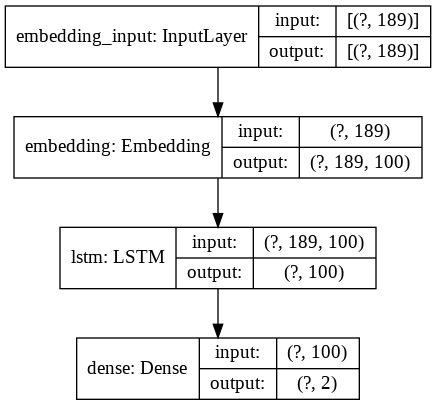

In [ ]:
from IPython.display import Image
keras.utils.plot_model(rnn, "rnn_model.png", show_shapes=True)
Image(filename="rnn_model.png")

In [ ]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Epoch 1/3
70/70 [==============================] - 42s 601ms/step - loss: 0.1780 - precision: 0.9531 - accuracy: 0.9388 - val_loss: 0.0856 - val_precision: 0.9881 - val_accuracy: 0.9713
Epoch 2/3
70/70 [==============================] - 41s 589ms/step - loss: 0.0971 - precision: 0.9841 - accuracy: 0.9682 - val_loss: 0.0689 - val_precision: 0.9866 - val_accuracy: 0.9776
Epoch 3/3
70/70 [==============================] - 41s 587ms/step - loss: 0.0790 - precision: 0.9870 - accuracy: 0.9729 - val_loss: 0.0586 - val_precision: 0.9902 - val_accuracy: 0.9785


Our model gets around a 97% accuracy and 99% precision score.  This is fantastic right off the bat - but we can do better.

### Comparing Different Models

To begin, we will evaluate a network using an LSTM cell, a GRU cell, and a SimpleRNN cell.  We will use a standard hyperparameter set to evaluate the results and decide which two architectures we want to explore in depth based on the results.

In [ ]:
from keras.layers import LSTM, GRU, SimpleRNN

rnns = []

for func in [SimpleRNN, LSTM, GRU]:
    rnn = Sequential()
    rnn.add(embedding_layer)
    rnn.add(func(100,dropout=0.2, recurrent_dropout=0.2))
    rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

    rnn.compile(loss='categorical_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=metrics)
    rnns.append(rnn)

In [ ]:
for rnn, name in zip(rnns,['simple','lstm','gru']):
    print('\nTesting Cell Type: ',name,'========')
    rnn.fit(X_train, y_train_ohe, epochs=3, batch_size=64, validation_data=(X_test, y_test_ohe))


Testing Cell Type:  simple ========
Epoch 1/3
70/70 [==============================] - 13s 180ms/step - loss: 0.2958 - precision: 0.8776 - accuracy: 0.8838 - val_loss: 0.1481 - val_precision: 0.9404 - val_accuracy: 0.9498
Epoch 2/3
70/70 [==============================] - 12s 176ms/step - loss: 0.1726 - precision: 0.9351 - accuracy: 0.9368 - val_loss: 0.1959 - val_precision: 0.9232 - val_accuracy: 0.9184
Epoch 3/3
70/70 [==============================] - 12s 177ms/step - loss: 0.1557 - precision: 0.9512 - accuracy: 0.9484 - val_loss: 0.1431 - val_precision: 0.9489 - val_accuracy: 0.9363

Testing Cell Type:  lstm ========
Epoch 1/3
70/70 [==============================] - 42s 603ms/step - loss: 0.1893 - precision: 0.9508 - accuracy: 0.9271 - val_loss: 0.1276 - val_precision: 0.9889 - val_accuracy: 0.9570
Epoch 2/3
70/70 [==============================] - 42s 597ms/step - loss: 0.0961 - precision: 0.9910 - accuracy: 0.9661 - val_loss: 0.1039 - val_precision: 0.9840 - val_accuracy: 0.967

As we can see, the GRU model performs the best by a large margin.  If we continue to train the GRU model it seems that we will get some really great results.  We will try also try to find the best hyperparameters for the GRU model.

After we find the best GRU results we will use an LSTM and then measure the results of the LSTM.

### Gridsearch on GRU Model

In [ ]:
dropouts=[.1,.2,.3]
recurrent_dropouts=[.1,.2,.3]

for dropout in dropouts:
    for recurrent_dropout in recurrent_dropouts:
        rnn = Sequential()
        rnn.add(embedding_layer)
        rnn.add(func(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

        rnn.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)
        print("Hyper Paramater Set:\n\tdropout=%.1f\n\trecurrent_dropout=%.1f\n" % (dropout,recurrent_dropout))
        rnn.fit(X_train,y_train_ohe,epochs=3, batch_size=64, validation_data=(X_test,y_test_ohe))
        print("\n")

Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.1

Epoch 1/3
70/70 [==============================] - 41s 582ms/step - loss: 0.1952 - precision: 0.9578 - accuracy: 0.9267 - val_loss: 0.1102 - val_precision: 0.9923 - val_accuracy: 0.9641
Epoch 2/3
70/70 [==============================] - 41s 581ms/step - loss: 0.0850 - precision: 0.9947 - accuracy: 0.9724 - val_loss: 0.0668 - val_precision: 0.9961 - val_accuracy: 0.9803
Epoch 3/3
70/70 [==============================] - 41s 579ms/step - loss: 0.0693 - precision: 0.9957 - accuracy: 0.9778 - val_loss: 0.0643 - val_precision: 0.9935 - val_accuracy: 0.9794


Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.2

Epoch 1/3
70/70 [==============================] - 41s 592ms/step - loss: 0.1986 - precision: 0.9523 - accuracy: 0.9213 - val_loss: 0.0854 - val_precision: 0.9905 - val_accuracy: 0.9731
Epoch 2/3
70/70 [==============================] - 41s 588ms/step - loss: 0.0917 - precision: 0.9907 - accuracy: 0.9717 - val_loss: 0.1513

###### We get some pretty ridiculously high accuracy with both of our hyperparameters set to .1

As we can see, with dropout and recurrent dropout at .1 we get some really great results; with accuracy getting as high as 98.6%.  This is ridiculously high.  The model gets .997 precision and .98 accuracy on the validation set with these hyperparameters.

We actually get a similar precision score in a few sets of hyperparameters, but we get a higher accuracy with the .1 and .1 set so this is our most effective model.

In [ ]:
best_model = Sequential()
best_model.add(embedding_layer)
best_model.add(GRU(100,dropout=.1, recurrent_dropout=.1))
best_model.add(Dense(NUM_CLASSES, activation='sigmoid'))
best_model.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)

### Training the Best Model With More Epochs

In [ ]:
best_model.fit(X_train,y_train_ohe,epochs=10, batch_size=64, validation_data=(X_test,y_test_ohe))

Epoch 1/10
70/70 [==============================] - 42s 599ms/step - loss: 0.1949 - precision: 0.9484 - accuracy: 0.9229 - val_loss: 0.1437 - val_precision: 0.9810 - val_accuracy: 0.9480
Epoch 2/10
70/70 [==============================] - 42s 594ms/step - loss: 0.0891 - precision: 0.9935 - accuracy: 0.9711 - val_loss: 0.0660 - val_precision: 0.9942 - val_accuracy: 0.9803
Epoch 3/10
70/70 [==============================] - 41s 591ms/step - loss: 0.0729 - precision: 0.9934 - accuracy: 0.9758 - val_loss: 0.0543 - val_precision: 0.9927 - val_accuracy: 0.9830
Epoch 4/10
70/70 [==============================] - 41s 587ms/step - loss: 0.0615 - precision: 0.9941 - accuracy: 0.9791 - val_loss: 0.0560 - val_precision: 0.9936 - val_accuracy: 0.9776
Epoch 5/10
70/70 [==============================] - 41s 591ms/step - loss: 0.0507 - precision: 0.9953 - accuracy: 0.9852 - val_loss: 0.0464 - val_precision: 0.9953 - val_accuracy: 0.9848
Epoch 6/10
70/70 [==============================] - 41s 586ms/ste

###### We end up getting above 99.5% accuracy and a precision score of .9986 on the validation set!  We could absolutely use this to publish a spam filter.  This is a very good score on this dataset - within a tenth of a percent of state of the art on both metrics

### Grid Search Using LSTM

Now that we know we can get results as high as 99.5% accuracy and 99.8% precision with the GRU network we will try to see how high we can get our LSTM's score.

In [ ]:
dropouts=[.1,.2,.3]
recurrent_dropouts=[.1,.2,.3]

for dropout in dropouts:
    for recurrent_dropout in recurrent_dropouts:
        rnn = Sequential()
        rnn.add(embedding_layer)
        rnn.add(LSTM(100,dropout=dropout, recurrent_dropout=recurrent_dropout))
        rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))

        rnn.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)
        print("Hyper Paramater Set:\n\tdropout=%.1f\n\trecurrent_dropout=%.1f" % (dropout,recurrent_dropout))
        rnn.fit(X_train,y_train_ohe,epochs=3, batch_size=64, validation_data=(X_test,y_test_ohe))
        print("\n")

Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.1
Epoch 1/3
70/70 [==============================] - 46s 652ms/step - loss: 0.1780 - precision: 0.9755 - accuracy: 0.9383 - val_loss: 0.0878 - val_precision: 0.9966 - val_accuracy: 0.9758
Epoch 2/3
70/70 [==============================] - 46s 651ms/step - loss: 0.0946 - precision: 0.9920 - accuracy: 0.9699 - val_loss: 0.0777 - val_precision: 0.9969 - val_accuracy: 0.9749
Epoch 3/3
70/70 [==============================] - 45s 649ms/step - loss: 0.0730 - precision: 0.9963 - accuracy: 0.9747 - val_loss: 0.0612 - val_precision: 0.9960 - val_accuracy: 0.9758


Hyper Paramater Set:
	dropout=0.1
	recurrent_dropout=0.2
Epoch 1/3
70/70 [==============================] - 46s 650ms/step - loss: 0.1828 - precision: 0.9588 - accuracy: 0.9341 - val_loss: 0.0954 - val_precision: 0.9912 - val_accuracy: 0.9686
Epoch 2/3
70/70 [==============================] - 45s 637ms/step - loss: 0.0978 - precision: 0.9889 - accuracy: 0.9655 - val_loss: 0.0741 -

###### As we can see, our best LSTM hyper parameter set is with a dropout of .1 and a recurrent dropout of .2.  We will create this network and train it with more epochs.

In [ ]:
best_lstm = Sequential()
best_lstm.add(embedding_layer)
best_lstm.add(LSTM(100,dropout=.1, recurrent_dropout=.2))
best_lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
best_lstm.compile(loss='categorical_crossentropy', 
                      optimizer='rmsprop', 
                      metrics=metrics)

### Comparison of models

In [ ]:
%%time

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score

sss = StratifiedShuffleSplit(n_splits=3)

gru_scores = []
gru_cms = []
lstm_scores = []
lstm_cms = []

split_num = 1
for train_index, test_index in sss.split(sequences, y_ohe):
    print('Split #{}'.format(split_num))
    split_num += 1
    X_train, X_test = sequences[train_index], sequences[test_index]
    y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
    
    # one hot decode for scoring
    y_test = [list(x).index(1.0) for x in list(y_test_ohe)] 
    
    best_model.fit(X_train,y_train_ohe,epochs=3,
                   batch_size=64,validation_data=(X_train,y_train_ohe),verbose=0)
    y_hat = best_model.predict(X_test)
    
    # one hot decode for scoring
    y_hat = np.array([[0,1] if np.argmax(x) == 1 else [1,0] for x in y_hat]).astype(float)
    y_hat = [list(x).index(1.0) for x in list(y_hat)]
    
    gru_scores.append(precision_score(y_test, y_hat))
    gru_cms.append(confusion_matrix(y_test, y_hat))
    
    print(gru_scores[-1])
    print(gru_cms[-1])
    
    best_lstm.fit(X_train,y_train_ohe,epochs=3,
                   batch_size=64,validation_data=(X_train,y_train_ohe),verbose=0)
    y_hat = best_lstm.predict(X_test)
    
    # one hot decode for scoring
    y_hat = np.array([[0,1] if np.argmax(x) == 1 else [1,0] for x in y_hat]).astype(float)
    y_hat = [list(x).index(1.0) for x in list(y_hat)]
    
    lstm_scores.append(precision_score(y_test, y_hat))
    lstm_cms.append(confusion_matrix(y_test, y_hat))
    
    print(lstm_scores[-1])
    print(lstm_cms[-1])

Split #1
0.9979296066252588
[[ 74   1]
 [  1 482]]
0.989648033126294
[[ 70   5]
 [  5 478]]
Split #2
0.9938271604938271
[[ 72   3]
 [  0 483]]
0.9877300613496932
[[ 69   6]
 [  0 483]]
Split #3
1.0
[[ 75   0]
 [  0 483]]
0.9897540983606558
[[ 70   5]
 [  0 483]]
CPU times: user 22min 4s, sys: 3min 6s, total: 25min 10s
Wall time: 15min 34s


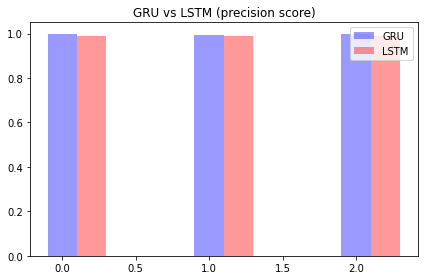

In [ ]:
# Plot bar graphs
bar_width = 0.20
index = np.arange(3)
opacity=0.4

plt.bar(index, gru_scores, bar_width, align='center',
        color='b', label='GRU', alpha=opacity)
plt.bar(index + bar_width, lstm_scores, bar_width,
        align='center', color='r', label='LSTM', alpha=opacity)
plt.title('GRU vs LSTM (precision score)')

plt.legend()
plt.tight_layout()
plt.show()

Both models perform extremely well, however the GRU model performed just a bit better.
   
By looking at heatmaps of the confusion matrices we can get a more granular look into how our models classify each class.

Text(0.5, 1.0, 'Heatmap of GRU')

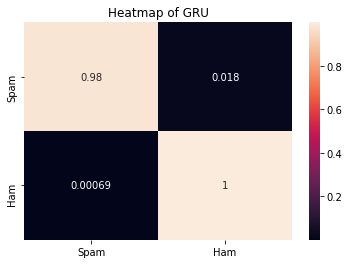

In [ ]:
# Plot heatmap
import seaborn as sns
labels = ['Spam', 'Ham']
gru_cm_avg = np.zeros((2,2))
for cm in gru_cms:
    # turn cm into percentages
    totals = np.repeat(np.sum(cm, axis=1), 2, axis=0).reshape(2,2)
    cm_ = cm / totals / 3
    gru_cm_avg = np.sum([gru_cm_avg, cm_], axis=0)
    
sns.heatmap(gru_cm_avg, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Heatmap of GRU')

Text(0.5, 1.0, 'Heatmap of lstm')

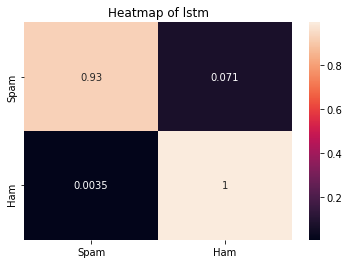

In [ ]:
# Plot heatmap
lstm_cm_avg = np.zeros((2,2))
for cm in lstm_cms:
    # turn cm into percentages
    totals = np.repeat(np.sum(cm, axis=1), 2, axis=0).reshape(2,2)
    cm_ = cm / totals / 3
    lstm_cm_avg = np.sum([lstm_cm_avg, cm_], axis=0)
    
sns.heatmap(lstm_cm_avg, annot=True, xticklabels=labels, yticklabels=labels)
plt.title('Heatmap of lstm')

From the heatmaps we can see that ham gets classified nearly perfectly using both models, however our GRU model scores much better than the LSTM when classifying spam instances.

## NLTK tokenize vs keras tokenizer

In [ ]:
!pip install nltk

We thought it could be interesting to compare the generalized NLTK tokenizer to the keras tokenizer.  We decided to compare them using basic LSTM networks.

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
X_nltk = [word_tokenize(x) for x in X]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
encoder = {}
counter = 0
def encode_sentence(seq):
    global encoder, counter
    fseq = []
    for x in seq:
        if x not in encoder:
            encoder[x] = counter
            counter+=1
        fseq.append(encoder[x])
    return fseq

X_nltk = [encode_sentence(x) for x in X]
X_nltk = pad_sequences(X_nltk, maxlen=None)

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=len(X_nltk[0]),
                            trainable=False)

In [ ]:
rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=metrics)
print(rnn.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 910, 100)          900800    
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 202       
Total params: 981,402
Trainable params: 80,602
Non-trainable params: 900,800
_________________________________________________________________
None


In [ ]:
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X_nltk, y_ohe, test_size=0.2,
                                                            stratify=y_ohe, 
                                                            random_state=42)

In [ ]:
rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=64)

Epoch 1/3
70/70 [==============================] - 215s 3s/step - loss: 0.3229 - precision: 0.9038 - accuracy: 0.8829 - val_loss: 0.1771 - val_precision: 0.9716 - val_accuracy: 0.9462
Epoch 2/3
70/70 [==============================] - 214s 3s/step - loss: 0.2318 - precision: 0.9379 - accuracy: 0.9226 - val_loss: 0.1474 - val_precision: 0.9650 - val_accuracy: 0.9552
Epoch 3/3
70/70 [==============================] - 216s 3s/step - loss: 0.1912 - precision: 0.9454 - accuracy: 0.9381 - val_loss: 0.1315 - val_precision: 0.9627 - val_accuracy: 0.9587


Unfortunately it's obvious that the built in keras tokenizer is leagues behind the GloVe embeddings.

# Conclusion
Different RNN cell types can drastically impact the performance of an RNN.

In the Spam vs Ham dataset GRU cells outperformed LSTM and Simple RNN cells.

With sufficient data our models could be used for mass scale spam text detection.